# Generates a flow (demand) file
#### Either fully random or it is possible to determine some main roads and side roads and generate different demand levels on them

In [1]:
# add the root to sys.path
import sys
sys.path.append('/Users/vinz/Documents/ETH/Do4/Simulation')

from generator.read_roadmap import read_roadmap
from generator.write_json import write_json_flow_file

from collections import Counter
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def plot_distribution(routes_dict, num_vehicles):
    num_plots = len(num_vehicles)
    num_cols = 2
    num_rows = (num_plots + num_cols - 1) // num_cols
    
    # Define the bucket size
    bucket_size = 50

    # Calculate the number of bins based on the bucket size
    num_bins = int((max(max(values) for values in num_vehicles.values()) + bucket_size) / bucket_size)
    
    vehicles_per_hour = 0
    for values in num_vehicles.values():
        vehicles_per_hour += len(np.array(values)[np.array(values) < 3600])

    # Create the subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 8))
    
    # total frequencies and bins
    total_frequencies = {}
    total_bins = {}

    # Plot the distribution for each key
    for (key, values), ax in zip(num_vehicles.items(), axes.flatten()):
        frequencies, bins, _ = ax.hist(values, bins=num_bins, alpha=0.9)
        ax.set_title(key)
        ax.grid(alpha = 0.7)
        
        total_frequencies[key] = frequencies
        total_bins[key] = bins

    # Remove any empty subplots
    if num_plots < num_rows * num_cols:
        for ax in axes.flatten()[num_plots:]:
            ax.axis('off')

    # Adjust the layout
    plt.tight_layout()
    
    fig.suptitle(f"Total Vehicles per hour: {vehicles_per_hour} veh/h", fontsize=12, fontweight='bold')
    plt.subplots_adjust(top=0.9)

    # Display the plot
    plt.show()
    
    return total_frequencies, total_bins

In [7]:
def main(subdirect, random_routes, random_vehicle_parameters):
    
    Road_map_Json = f"../Simulation_Results/{subdirect}/roadnet.json"
    Dir_FlowFile_Json = f"../Simulation_Results/{subdirect}/"
    FlowFile_Json = "flow.json"
    
    # if we want inflow / outflow from specific lanes, we can just overwrite roads_IN and roads_OUT
    roads_IN, roads_OUT, road_adj_to_IN, roads_INSIDE = read_roadmap(Road_map_Json)
    
    # "Fixed" or random vehicle routes (e.g. main and side roads)
    # ratio: what percentage [0,1] of all possible inflow-outflow combinations will have vehicles
    # effective_interval: what is the effective interval between 2 vehicles on a road (even with multiple routes starting from the same road)
    if random_routes:
        # what percentage [0,1] of all possible inflow and outflow combinations will be considered
        parameters = {
            "traffic_ratio_out": 0.7,
            "traffic_ratio_in": 0.002,
            "interval": 70.0
        }
        
    else:
        # True, if entry and exit main lanes are already grouped together
        # if set to false, then main_roads is a single list with all main_roads
        predefined_main = True
        
        main_roads = {
            0: ["road_0_4_0", "road_30_4_0"],
            1: ["road_31_4_2", "road_1_4_2"],
            2: ["road_0_11_0", "road_30_11_0"],
            #3: ["road_31_11_2", "road_1_11_2"],
            4: ["road_0_9_0", "road_30_9_0"],
            5: ["road_31_9_2", "road_1_9_2"],
            6: ["road_0_5_0", "road_4_5_1", "road_4_11_0", "road_17_11_1"],
            7: ["road_31_9_2", "road_17_9_2", "road_16_9_3", "road_16_1_3"],
            8: ["road_31_6_2", "road_17_6_1", "road_17_11_1"],
            9: ["road_0_10_0", "road_30_10_0"],
            10: ["road_16_0_1", "road_16_11_1"]
        }
        
        parameters = {
            "predefined_main": predefined_main,
            "main_roads": main_roads,
            # the remaining roads are side roads
            "side_roads": roads_IN.union(roads_OUT).difference(main_roads),
            "mtm": {"ratio": 0.8, "effective_interval": 10},
            "mts": {"ratio": 0.13, "effective_interval": 45},
            "sts": {"ratio": 0.018, "effective_interval": 45},    # effective interval only works if start time = 0
            "stm": {"ratio": 0.042, "effective_interval": 40},
            "ito": {"ratio": 0.00026, "effective_interval": 45},
            "oti": {"ratio": 0.00023, "effective_interval": 45},
            "iti": {"ratio": 0.0039, "effective_interval": 40},
            "horizontal": {"ratio": 0.00055, "effective_interval": 45},
            "top": {"ratio": 0.75, "effective_interval": 30},
            "left": {"ratio": 0.04, "effective_interval": 30},
            "bottom": {"ratio": 0.027, "effective_interval": 30},
            "only_bottom": {"ratio": 1, "effective_interval": 5},
            "only_top": {"ratio": 0.85, "effective_interval": 9},
        }
        
            

    
    # Fixed or random vehicle parameters
    if random_vehicle_parameters:
        write_json_flow_file(
            vehLen =  5,
            vehWidth =  2,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            parameters = parameters,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
        
    else:
        routes_dict, num_vehicles = write_json_flow_file(
            vehLen =  5.0,
            vehWidth =  2.0,
            vehMaxPosAcc = 3.0,
            vehMaxNegAcc = 4.5,
            vehUsualPosAcc = 2.0,
            vehUsualNegAcc = 3.5,
            vehMinGap = 2.5, # 2.5
            vehMaxSpeed =  8.333, # 14 m/s ~ 50 km/h
            vehHeadwayTime = 10,
            parameters = parameters,
            roads_IN = roads_IN,
            roads_OUT = roads_OUT,
            road_adj_to_IN = road_adj_to_IN,
            roads_INSIDE = roads_INSIDE,
            directory = Dir_FlowFile_Json,
            FlowFile = FlowFile_Json,
            random_routes = random_routes,
            random_vehicle_parameters = random_vehicle_parameters
        )
    
        # Plot distribution of generated vehicles
        total_frequencies, total_bins = plot_distribution(routes_dict, num_vehicles)
        
        
        return total_frequencies, total_bins

{'mtm': '4/10', 'mts': '50/103', 'sts': '61/114', 'stm': '14/33', 'ito': '10/22', 'oti': '7/19', 'iti': '97/97', 'horizontal': '21/22', 'top': '0/140', 'left': '299/329', 'bottom': '0/325', 'only_bottom': '0/45', 'only_top': '0/43'}
Number of routes generated (does not give all information about number of cars generated (different intervals))
mtm: 10
mts: 103
sts: 114
stm: 33
ito: 22
oti: 19
iti: 97
horizontal: 22
top: 140
left: 329
bottom: 325
only bottom: 45
only top: 43
Total flows: 1302
Successful created a flow file!


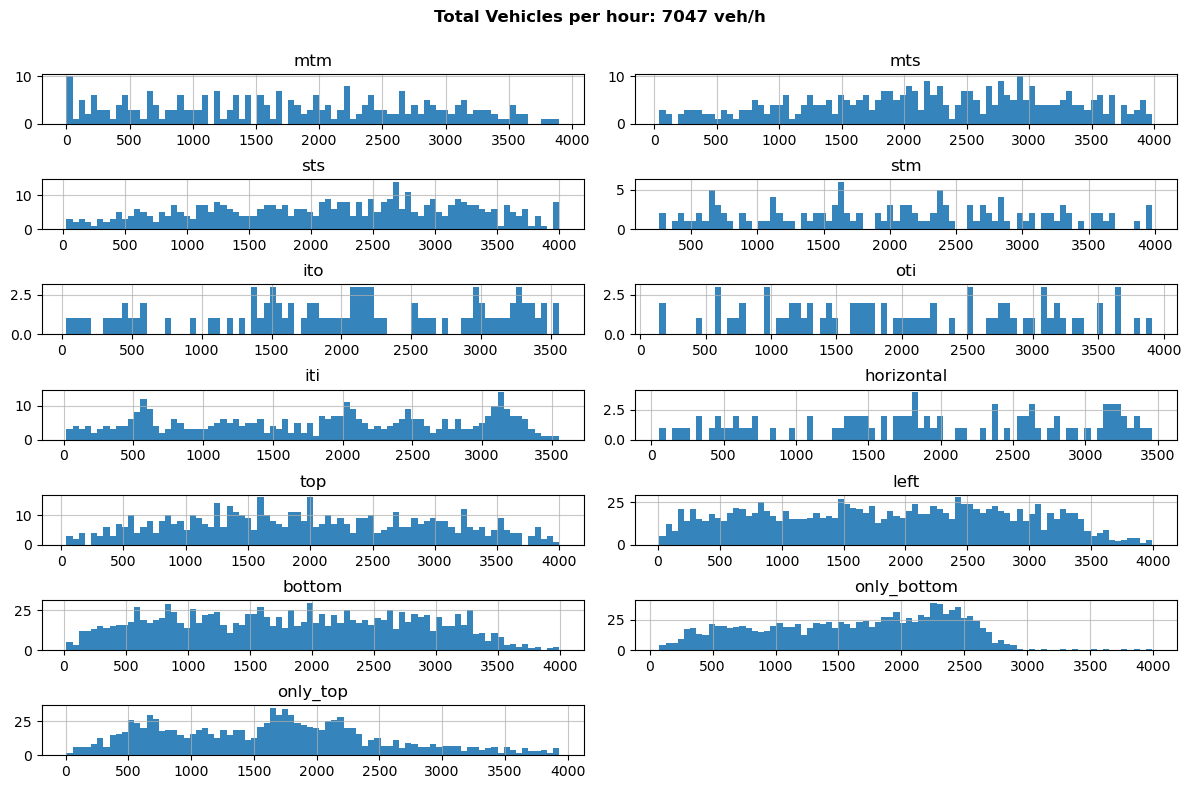

In [8]:
if __name__ == "__main__":
    
    # random vehicle routes
    random_routes = False
    
    # random vehicle parameters
    random_vehicle_parameters = False
    
    # sub directory of the roadnet file
    subdirect = "Manhattan"
    
    total_frequencies, total_bins = main(subdirect, random_routes, random_vehicle_parameters)

In [9]:
# Get the values from the dictionary
arrays = list(total_frequencies.values())

# Use zip to iterate over the corresponding elements
result = np.sum(list(zip(*arrays)), axis=1)

pair_sums = np.array([int(sum(result[i:i+2])) for i in range(0, len(result), 2)])

pair_sums

array([ 83, 112, 153, 142, 199, 223, 234, 196, 222, 187, 206, 194, 219,
       210, 217, 239, 251, 235, 255, 248, 245, 251, 300, 228, 235, 212,
       199, 190, 162, 157, 152, 139, 153, 130, 104,  99,  84,  56,  48,
        46])